In [6]:
# import generator from '../data/generator.py'
import sys
import os
from generator import RandomGraphDataset

# Graph Generation

In [7]:
n = [20, 100]
p = 0.3

dataset = RandomGraphDataset(root='./data', gen_num_graph=100, n=n, p=p)

In [10]:
import torch
from torch import nn
from encoder import Encoder
from decoder import Decoder
from mpnn import MPNN
from torch.functional import F

class Network(nn.Module):
    def __init__(self, latent_dim=128):
        super(Network, self).__init__()
        self.encoder = Encoder(2, latent_dim)
        self.processor = MPNN(latent_dim*2, latent_dim)
        self.decoder = Decoder(latent_dim, 1)

    def forward(self, batch, max_iter=10):
        input = torch.stack((batch.pos, batch.s), dim=1).float()
        h = torch.zeros(input.size(0), 128) # hidden state from the processor
        hints_edges = batch.pi_h[1:] # hints if an edge was passed or not
        true_output = batch.pi # true_output for all the edges if they were passed or not at the end.
        max_iter = hints_edges.size(0)

        hints_reach = batch.reach_h[1:] # hints from the reachability
        true_output_reach = batch.reach_h[-1] # true_output expected from the reachability
        
        predictions_edges = torch.zeros(max_iter, batch.pi.size(0))
        predictions_reach = torch.zeros(max_iter, batch.s.size(0))
        predictions_parents = torch.zeros(max_iter, batch.s.size(0))
        real_parents = torch.zeros(max_iter, batch.s.size(0))

        for i in range(max_iter):
            # NETWORK START
            z = self.encoder(input) # the encoded input
            processor_input = torch.cat([z, h], dim=1) # the input to the processor
            h = self.processor(processor_input, batch.edge_index.long()) # the output of the processor
            decoder_input = torch.cat((h[batch.edge_index[0]], h[batch.edge_index[1]]), dim=1)
            alpha = self.decoder(decoder_input).view(batch.pi.size(0))
            # NETWORK END

            # predictions for the edges
            predictions_edges[i] = alpha.view(batch.pi.size(0))

            # predictions for the reachability
            predictions_reach[i] = self.calculate_reach(batch, alpha)
            # update the input with the new state
            input = torch.stack((batch.pos, predictions_reach[i]), dim=1).float()

            # predictions for the parents
            predictions_parents[i] = self.calculate_parents(alpha, batch.edge_index, batch.s)
            real_parents[i] = self.calculate_parents(batch.pi_h[i], batch.edge_index, batch.s)
            
        loss_edges = self.calculate_loss(hints_edges, predictions_edges, true_output)
        loss_reach = self.calculate_loss(hints_reach, predictions_reach, true_output_reach)
        loss_parents = self.calculate_parents_loss(real_parents, predictions_parents, real_parents[-1])
        
        return loss_edges, loss_reach, loss_parents
    
    def calculate_loss(self, hints, predictions, true_output):
        loss_x = F.binary_cross_entropy(predictions[-1], true_output.type(torch.float))
        loss_h = 0
        for i in range(hints.size(0)):
            loss_h += F.binary_cross_entropy(predictions[i], hints[i].type(torch.float))
        return loss_x, loss_h
    
    def calculate_reach(self, graph, alpha):
        """
        Calculate reachability values for each node from the alpha values

        Args:
        - batch: PyTorch tensor or object containing graph data
        - alpha: PyTorch tensor containing alpha values

        Returns:
        - y: PyTorch tensor containing reachability values for each node
        """
        y = torch.zeros((len(graph.s)))
        for node_index in range(0, len(graph.s)):
            alpha_max_proba = alpha[torch.logical_or(graph.edge_index[0] == node_index, graph.edge_index[1] == node_index)].max()
            if alpha_max_proba.item() >= 0.8:
                y[node_index] = 1
        return y
    
    def calculate_parents(self, pi, edge_index, s):
        parents = torch.full((len(s),), -1, dtype=torch.long)
        for child in range(len(s)):
            indices = (edge_index[1] == child).nonzero(as_tuple=False).squeeze()
            passed_indices = indices[pi[indices] == 1]
            if passed_indices.numel() > 0:
                parent_index = edge_index[0, passed_indices[0]]
                parents[child] = parent_index.item()
        return parents
    
    def calculate_parents_loss(self, real_parents, predictions_parents, final_parents):
        loss_x = torch.mean(torch.eq(predictions_parents[-1], final_parents).float())
        loss_h = 0
        for i in range(real_parents.size(0)):
            loss_h += torch.mean(torch.eq(predictions_parents[i], real_parents[i]).float())
        return 1 - loss_x, 1 - loss_h/real_parents.size(0)

In [11]:
def train(model, train_dataset, validation_dataset=None, optimizer=None, epochs=10, batch_size=5):
    x_loss_weight = 0.5
    h_loss_weight = 1 - x_loss_weight

    loss_edges_train, loss_reach_train, loss_parents_train = [], [], []

    for epoch in range(epochs):
        batch_count = len(train_dataset) // batch_size
        for i in range(batch_count):
            model.train()
            cumulated_loss_edges, cumulated_loss_reach, cumulated_loss_parents = 0, 0, 0
            for j in range(i * batch_size, (i + 1) * batch_size):
                graph = train_dataset[j] 
                loss_edges, loss_reach, loss_parents = model(graph)
                loss_edges_output, loss_edges_hints = loss_edges[0], loss_edges[1]  # loss for the edges
                loss_reach_output, loss_reach_hints = loss_reach[0], loss_reach[1]  # loss for the reachability
                loss_parents_output, loss_parents_hints = loss_parents[0], loss_parents[1]  # loss for the parents

                cumulated_loss_edges += x_loss_weight * loss_edges_output + h_loss_weight * loss_edges_hints
                cumulated_loss_reach += x_loss_weight * loss_reach_output + h_loss_weight * loss_reach_hints
                cumulated_loss_parents += x_loss_weight * loss_parents_output + h_loss_weight * loss_parents_hints
            
            cumulated_loss_edges /= batch_size
            cumulated_loss_reach /= batch_size
            cumulated_loss_parents /= batch_size
            
            optimizer.zero_grad()
            cumulated_loss_edges.backward()
            optimizer.step()

            # Convert tensors to lists and append to the respective lists
            loss_edges_train.append(cumulated_loss_edges.item())
            loss_reach_train.append(cumulated_loss_reach.item())
            loss_parents_train.append(cumulated_loss_parents.item())

        if validation_dataset:
            loss_edges_val, loss_reach_val, loss_parents_val = [], [], []

            model.eval()
            cumulated_loss_edges_val, cumulated_loss_reach_val, cumulated_loss_parents_val = 0, 0, 0
            with torch.no_grad():
                for k in range(len(validation_dataset)):
                    graph = validation_dataset[k]
                    loss_edges, loss_reach, loss_parents = model(graph)
                    loss_edges_output, loss_edges_hints = loss_edges[0], loss_edges[1]  # loss for the edges
                    loss_reach_output, loss_reach_hints = loss_reach[0], loss_reach[1]  # loss for the reachability
                    loss_parents_output, loss_parents_hints = loss_parents[0], loss_parents[1]  # loss for the parents
                    
                    cumulated_loss_edges_val += x_loss_weight * loss_edges_output + h_loss_weight * loss_edges_hints
                    cumulated_loss_reach_val += x_loss_weight * loss_reach_output + h_loss_weight * loss_reach_hints
                    cumulated_loss_parents_val += x_loss_weight * loss_parents_output + h_loss_weight * loss_parents_hints

                cumulated_loss_edges_val /= len(validation_dataset)
                cumulated_loss_reach_val /= len(validation_dataset)
                cumulated_loss_parents_val /= len(validation_dataset)

                loss_edges_val.append(cumulated_loss_edges_val.item())
                loss_reach_val.append(cumulated_loss_reach_val.item())
                loss_parents_val.append(cumulated_loss_parents_val.item())

            print(f'Epoch {epoch}, loss_edges {cumulated_loss_edges.item()}, loss_reach {cumulated_loss_reach.item()}, loss_parents {cumulated_loss_parents.item()}')
            print(f'Validation: Epoch {epoch}, loss_edges {cumulated_loss_edges_val.item()}, loss_reach {cumulated_loss_reach_val.item()}, loss_parents {cumulated_loss_parents_val.item()}')
        else:
            print(f'Epoch {epoch}, loss_edges {cumulated_loss_edges.item()}, loss_reach {cumulated_loss_reach.item()}, loss_parents {cumulated_loss_parents.item()}')

    return loss_edges_train, loss_reach_train, loss_parents_train



In [12]:
# split the dataset into training and testing using the train_test_split function
from torch.utils.data import random_split
from generator import RandomGraphDataset
n=[20, 50]
p=0.3
dataset = RandomGraphDataset(root='./data/medium', gen_num_graph=200, n=n, p=p)
train_dataset, test_dataset = random_split(dataset, [150, 50])

In [20]:
lr = 0.0005

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = Network()
model.to(device)
optimizer = torch.optim.Adam

loss_edges_train, loss_reach_train, loss_parents_train = train(model=model, train_dataset=train_dataset,
      optimizer=optimizer(model.parameters(), lr=lr), epochs=10, batch_size=32)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [5]:
# split the dataset into training and testing using the train_test_split function
from torch.utils.data import random_split
n=[20, 100]
p=0.3
dataset = RandomGraphDataset(root='./data', gen_num_graph=500, n=n, p=p)
train_dataset, test_dataset = random_split(dataset, [400, 100])

Generating 500 graphs


100%|██████████| 500/500 [00:02<00:00, 206.15it/s]
Processing...
100%|██████████| 500/500 [00:14<00:00, 35.58it/s]
Done!


In [ ]:
# create a test set
n=[100, 1000]
p=0.3

test_dataset = RandomGraphDataset(root='./data/test', gen_num_graph=100, n=n, p=p)

In [17]:
optimizer = torch.optim.Adam
model = Network()
lr = 0.001

train_loss, val_losses = train(model=model, train_dataset=train_dataset, validation_dataset=test_dataset,
      optimizer=optimizer(model.parameters(), lr=lr), epochs=15, batch_size=32)

Epoch 0, loss 0.474441260099411, validation loss 0.483560174703598
Epoch 1, loss 0.2088150680065155, validation loss 0.18745948374271393
Epoch 2, loss 0.008495943620800972, validation loss 0.006550794932991266
Epoch 3, loss 0.00042512972140684724, validation loss 0.00037600912037305534
Epoch 4, loss 9.510121890343726e-05, validation loss 9.221333311870694e-05
Epoch 5, loss 4.748110950458795e-05, validation loss 4.7312365495599806e-05
Epoch 6, loss 3.1041312468005344e-05, validation loss 3.187461697962135e-05
Epoch 7, loss 2.4472823497490026e-05, validation loss 2.5687741072033532e-05
Epoch 8, loss 2.107813816110138e-05, validation loss 2.2359427021001466e-05
Epoch 9, loss 1.8665112293092534e-05, validation loss 1.9870582036674023e-05
Epoch 10, loss 1.6638863598927855e-05, validation loss 1.77220645127818e-05
Epoch 11, loss 1.4860472219879739e-05, validation loss 1.5818113752175122e-05
Epoch 12, loss 1.3286005014379043e-05, validation loss 1.4136039681034163e-05
Epoch 13, loss 1.1898310

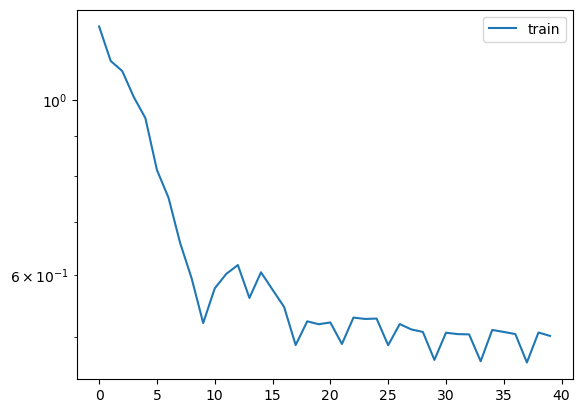

In [54]:
# plot the losses
import matplotlib.pyplot as plt
plt.plot(loss_edges_train, label='train')
plt.legend()
# use log scale
plt.yscale('log')
plt.show()

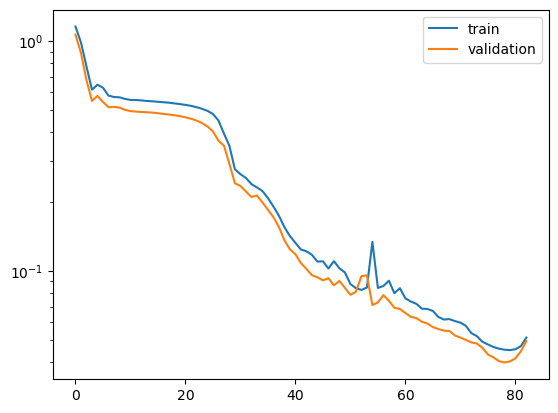

In [25]:
plt.plot(train_loss, label='train')
plt.plot(val_losses, label='validation')
plt.legend()
# use log scale
plt.yscale('log')
plt.show()

In [ ]:
i =31
graph = test_dataset[i]
print(graph.reach_h[-1])
print(torch.sigmoid(model(graph)[0]))

tensor([1., 0., 1., 1., 1., 0.], dtype=torch.float64)
tensor([1.0000, 0.0507, 1.0000, 1.0000, 1.0000, 0.0255],
       grad_fn=<SigmoidBackward0>)


In [ ]:
model(graph)[0]

tensor([3500525.5000, 3524301.5000, 3249399.0000, 3501471.5000, 3512054.0000,
        3518177.7500], grad_fn=<ViewBackward0>)

In [35]:
(dataset[0].pi_h[-1] == dataset[0].pi).all()

tensor(True)

In [ ]:
Network().forward(input, dataset[0].edge_index)

tensor([[-0.0748],
        [-0.0829],
        [-0.0641],
        [-0.0551],
        [-0.0525],
        [-0.0458]], grad_fn=<AddmmBackward0>)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super(Encoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.lin = nn.Linear(input_dim, hidden_dim)

    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(-1)
        return self.lin(x)

In [ ]:
encoder = Encoder(2)
z = encoder(input)

In [ ]:
h = torch.zeros(input.size(0), 128)

In [ ]:
z_ = torch.cat([z, h], dim=1)
z_.size()

torch.Size([6, 256])

In [ ]:
import torch
from torch_geometric.nn import MessagePassing
from torch.nn import Linear

class MPNN(MessagePassing):
  def __init__(self, in_channels, hidden_channels, activation=None):
    super(MPNN, self).__init__(aggr='max') #  "Max" aggregation.
    self.in_channels = in_channels
    self.hidden_channels = hidden_channels
    self.messages = Linear(self.in_channels * 2, self.hidden_channels)
    self.update_fn = Linear(self.in_channels + self.hidden_channels, self.hidden_channels)
    self.activation = activation

    self.mlp = torch.nn.Sequential(
        Linear(hidden_channels, hidden_channels),
        torch.nn.ReLU(),
        Linear(hidden_channels, self.hidden_channels)
    )
    
  def forward(self, x, edge_index):
    out = self.propagate(edge_index, x=x)
    out = self.mlp(out)
    if self.activation is not None:
      out = self.activation(out)
    return out
    
  def message(self, x_i, x_j):
    # x_i has shape [E, in_channels]
    # x_j has shape [E, in_channels]
    #print('MPNN => xi, xj', x_i.size(), x_j.size())
    tmp = torch.cat([x_i, x_j], dim=1)  # tmp has shape [E, 2 * in_channels]
    #print('MPNN => messages IN', tmp.size())
    m = self.messages(tmp)
    #print('MPNN => messages OUT', m.size())
    return m
  
  def update(self, aggr_out, x):
    # aggr_out has shape [N, out_channels]
    # x has shape [N, in_channels]
    #print(f'MPNN => x_i', x.size(), ' aggr_out ', aggr_out.size())
    tmp = torch.cat([x, aggr_out], dim=1)
    #print(f'MPNN => tmp', tmp.size())
    return self.update_fn(tmp)

In [ ]:
processor = MPNN(256, 128)

In [ ]:
hi = processor(z_, dataset[0].edge_index)

In [ ]:
hi.size()

torch.Size([6, 128])